### Setup

In [1]:
%%bash
### Go to Quick start https://docs.wandb.com/quickstart and perform the steps before going further
found=$(pip show wandb || true)
if [[ -z "${found}" ]]; then
    pip install --upgrade wandb
    echo "W&B installed successfully"
else
    echo "W&B has already been installed"
fi

W&B has already been installed


In [2]:
import os

# supress warnings
import warnings
warnings.filterwarnings('ignore')

DEFAULT_MAX_ROWS = 1000

### Kaggle Kernel settings - uncomment on when running on Kaggle
# SOURCE_ROOT_DATA_FOLDER = '../input/sbfxcompetitionprocessdatasets/'
# TARGET_ROOT_DATA_FOLDER = '../working'

### Comment below two lines when running on Kaggle
SOURCE_ROOT_DATA_FOLDER = '../data'
TARGET_ROOT_DATA_FOLDER = '../data'

import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../library')

import importlib
visualisation_library = __import__("visualisation_library")
utility_library = __import__("utility_library")
process_data = __import__("process-data-lib")

Falling back to default / hard-coded value set in the program
SOURCE_ROOT_DATA_FOLDER = ../data/
Falling back to default / hard-coded value set in the program
TARGET_ROOT_DATA_FOLDER = ../data/


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# show plots without need of calling `.show()`
%matplotlib inline

# prettify plots
plt.rcParams['figure.figsize'] = [20.0, 5.0]
sns.set_palette(sns.color_palette("muted"))
sns.set_style("ticks")

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# When using Kaggle kernels, uncomment the below comments
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# api_token = user_secrets.get_secret("WANDB_TOKEN")

# Ensure you have started the Jupyter instance after setting the environment variable WANDB_TOKEN, 
# with your W&B Access token that can be found in your project page on https://www.wandb.com/
api_token = os.environ["WANDB_TOKEN"]

# You can permanently save the token in your .bashrc, .bash_profile, or .zshrc

# W&B Imports
import wandb
wandb.login(key=api_token)
wandb.init(reinit=True, project="sb-fx-comp")
print("Logged in successfully on W&B")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/swami/.netrc


Logged in successfully on W&B


In [5]:
wandb.config.stage="04"
wandb.config.method="02"
wandb.config.model="Linear Regression model"
wandb.config.RANDOM_SEED = 42
wandb.config.FEATURE_IMPORTANCE_CUTOFF = 0.00099 ### A rule-off thumb cutoff point, to filter out features of less or no importance
wandb.config.nRowsRead = 4500
wandb.config.test_size=0.20
wandb.config.input_training_dataset_filename = 'train.csv'
wandb.config.input_test_dataset_filename = 'test.csv'
wandb.config.feature_importance_filename = f'method-{wandb.config.method}-linear-model-feature-importance.csv'

In [6]:
final_training_dataset = process_data.load_dataset(SOURCE_ROOT_DATA_FOLDER, wandb.config.input_training_dataset_filename, nRowsRead=wandb.config.nRowsRead)
final_test_dataset = process_data.load_dataset(SOURCE_ROOT_DATA_FOLDER, wandb.config.input_test_dataset_filename, nRowsRead=wandb.config.nRowsRead)

There are 4177 rows and 229 columns in ../data/04-train-228-features-removed-redundant-columns-after-02.csv
There are 1000 rows and 228 columns in ../data/04-test-228-features-removed-redundant-columns-after-02.csv


In [ ]:
final_training_dataset.describe()

In [8]:
feature_column_names = [col for col in final_training_dataset.columns]
feature_column_names.remove('id')
feature_column_names.remove('target')

In [9]:
X = final_training_dataset[feature_column_names]
y = final_training_dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=wandb.config.test_size, random_state=wandb.config.RANDOM_SEED)

### Train model

In [10]:
# https://earlacademy.com/linear-regression-and-elasticnet-with-sklearn/
# We will use Linear model instead

linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
predictions = linearModel.predict(X_test)

### Ratios and metrics

In [12]:
print(f'Spearman Correlation: {spearmanr(y_test, predictions)[0]}')

Spearman Correlation: -0.013464546759619446


In [13]:
spearmanr(y_test, predictions)

SpearmanrResult(correlation=-0.013464546759619446, pvalue=0.6974651538686936)

In [14]:
print("Intercept: ", linearModel.intercept_)

Intercept:  1.0001440337328698


### Actual v/s predicted target variable

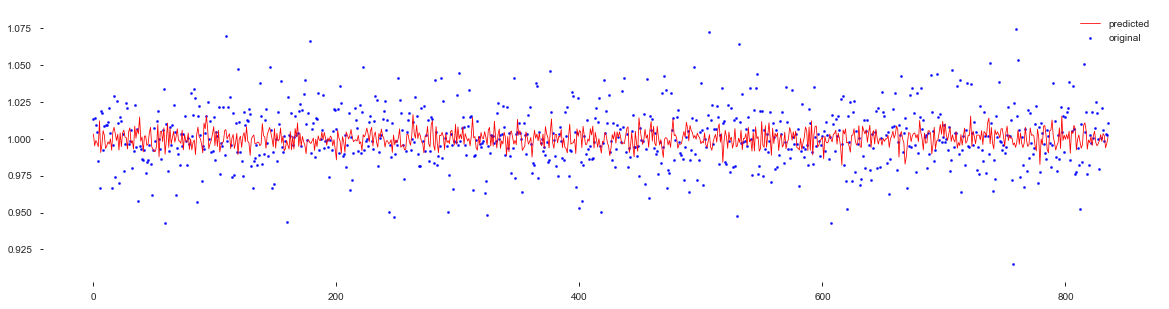

In [15]:
visualisation_library.plot_between(y_test, predictions)

### Feature Importance

49 features, reduction of 78.41% (feature importance cutoff score: 0.00099 and higher)


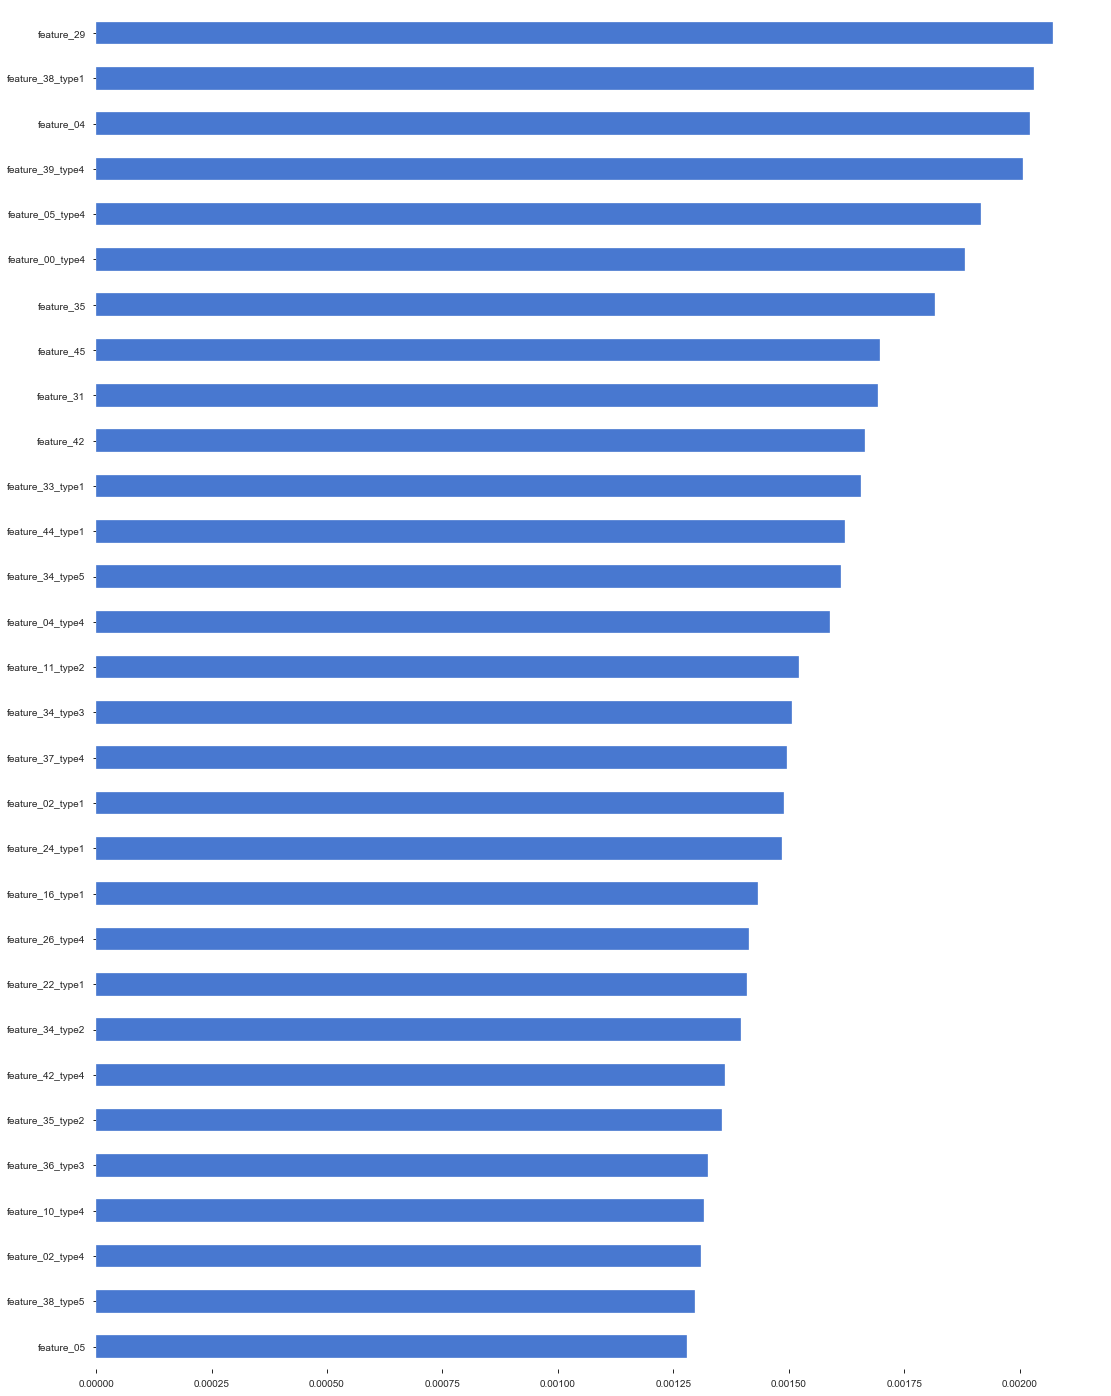

In [16]:
# https://www.kaggle.com/den3b81/elasticnet-lb-0-547-and-feature-importance#Feature-importance

feature_importance = pd.Series(index = X_train.columns, data = np.abs(linearModel.coef_))

n_selected_features = (feature_importance > wandb.config.FEATURE_IMPORTANCE_CUTOFF).sum()
reduction_in_features = (1 - n_selected_features / len(feature_importance)) * 100
print('{0:d} features, reduction of {1:2.2f}% (feature importance cutoff score: {2:0.5f} and higher)'.format(
    n_selected_features, reduction_in_features, wandb.config.FEATURE_IMPORTANCE_CUTOFF)
)

wandb.log({"features with importance": n_selected_features, 
           "reduction in features": reduction_in_features, 
           "total features": len(feature_column_names)})

plt.rcParams.update({'font.size': 22})
feature_importance.sort_values().tail(30).plot(kind = 'barh', figsize = (18,25))

In [17]:
feature_importance.sort_values(ascending=False).to_csv(os.path.join(TARGET_ROOT_DATA_FOLDER, wandb.config.feature_importance_filename)) ### in this case we DO NOT use index=False, because we want to save the index
feature_importance.sort_values(ascending=False).to_csv(os.path.join(wandb.run.dir, wandb.config.feature_importance_filename)) ### in this case we DO NOT use index=False, because we want to save the index
print(f'Saved the feature importance columns in descending order of their importance to {wandb.config.feature_importance_filename}')

Saved the feature importance columns in descending order of their importance to method-02-linear-model-feature-importance.csv


### Visualisation of residual (difference between predicted and actual)

In [18]:
import seaborn as sns

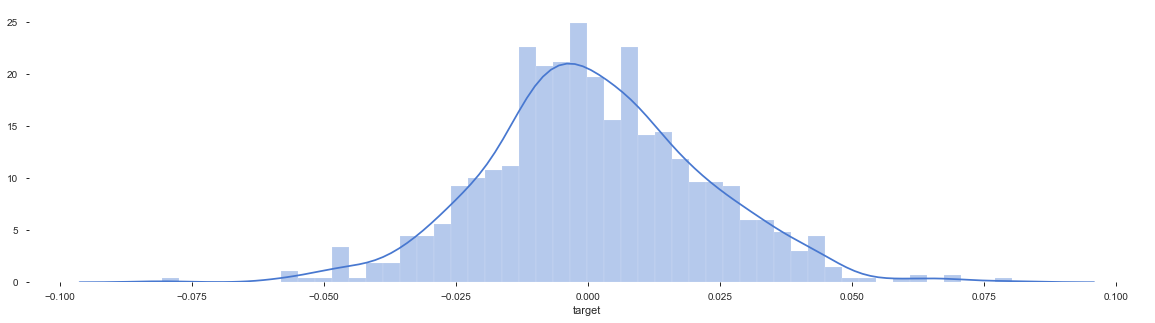

In [19]:
sns.distplot((y_test-predictions), bins=50)

### Training & testing metrics

In [20]:
metrics_scores = {'Explained Variance Score (EVS)': metrics.explained_variance_score(y_test, predictions),
'Mean Absolute Error (MAE)': metrics.mean_absolute_error(y_test, predictions),
'Mean Squared Error (MSE)': metrics.mean_squared_error(y_test, predictions),
'Root Mean Square Error (RMSE)': np.sqrt(metrics.mean_squared_error(y_test, predictions)),
'R2': metrics.r2_score(y_test, predictions),
'Spearman Correlation': spearmanr(y_test, predictions)[0],
'Spearman p-value': spearmanr(y_test, predictions)[1],
'Intercept': linearModel.intercept_
}

wandb.log(metrics_scores)
metrics_scores_df = pd.DataFrame(metrics_scores, index=[0])
metrics_scores_df

,Explained Variance Score (EVS),Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Square Error (RMSE),R2,Spearman Correlation,Spearman p-value,Intercept
0,-0.0701693766,0.0158473539,0.0004184923,0.0204570837,-0.0745973389,-0.0134645468,0.6974651539,1.0001440337


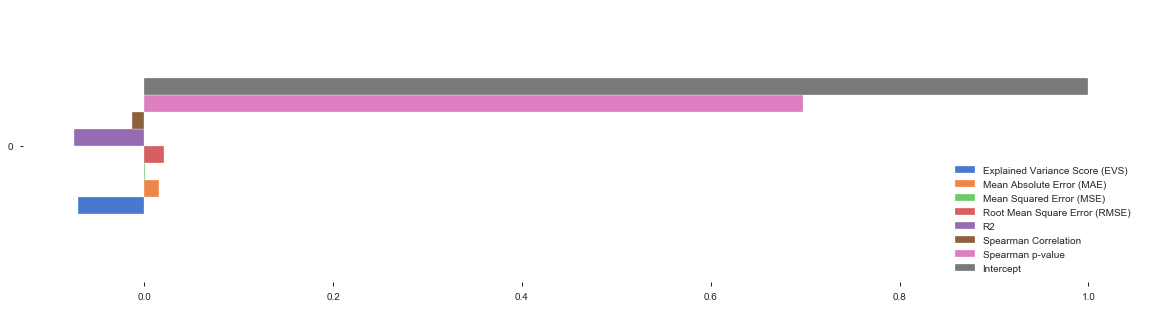

In [21]:
metrics_scores_df.plot.barh()

### Validation using the separate test dataset

In [22]:
validation_test = final_test_dataset[feature_column_names]

In [23]:
validation_predictions = linearModel.predict(validation_test)

In [ ]:
validation_predictions

### Submission and model creation

In [25]:
df_id = pd.DataFrame(final_test_dataset['id'])
df_target = pd.DataFrame(validation_predictions, columns = ['target'])
df_submission = pd.concat([df_id, df_target], axis=1, sort=False)

In [ ]:
df_submission

In [27]:
# method-02 == using Linear model
# https://earlacademy.com/linear-regression-and-elasticnet-with-sklearn/

def save_model_and_submission(model, dataframe, folder, method):
    saved_filename = utility_library.save_submission(dataframe, folder, method)
    
    model_filename, ext = os.path.splitext(saved_filename)
    model_filename = os.path.basename(model_filename) + ".pkl"

    print("~~~ Saving artifacts to disk ")
    utility_library.save_model(model, folder, model_filename)



In [28]:
method=f'method-{wandb.config.method}'
save_model_and_submission(linearModel, df_submission, TARGET_ROOT_DATA_FOLDER, method)
save_model_and_submission(linearModel, df_submission, wandb.run.dir, method)

print("~~~ Saving artifacts into W&B folder for further upload")
wandb.save(os.path.join(TARGET_ROOT_DATA_FOLDER, f'*{method}*.csv'))
wandb.save(os.path.join(TARGET_ROOT_DATA_FOLDER, f'*{method}*.pkl'))

Saved submission file to ../data/submission-method-02-96e757e-6ff2ae4.csv
~~~ Saving artifacts to disk 
Saved model to file ../data/submission-method-02-96e757e-6ff2ae4.pkl
Saved submission file to /home/user/workspace/wandb/run-20200107_164322-yyuwp9wa/submission-method-02-96e757e-6ff2ae4.csv
~~~ Saving artifacts to disk 
Saved model to file /Users/home/user/workspace/wandb/run-20200107_164322-yyuwp9wa/submission-method-02-96e757e-6ff2ae4.pkl
~~~ Saving artifacts into W&B folder for further upload


['/home/user/workspace/wandb/run-20200107_164322-yyuwp9wa/submission-method-02-96e757e-6ff2ae4.pkl',
 '/home/user/workspace/wandb/run-20200107_164322-yyuwp9wa/submission-method-02.pkl']

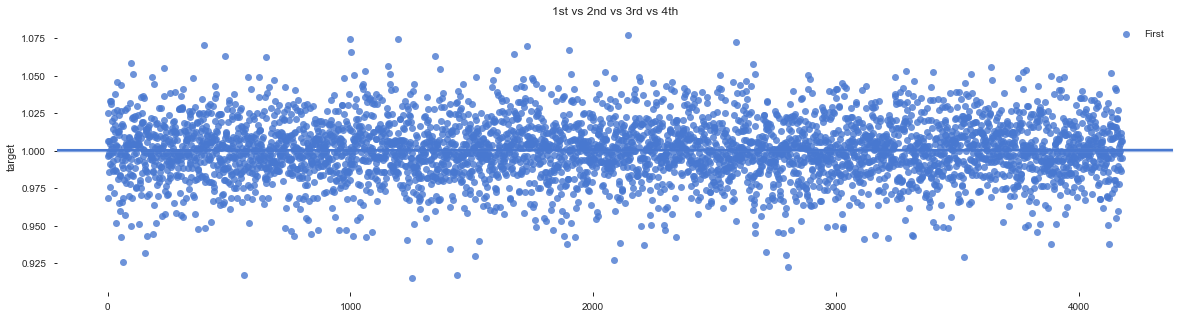

In [29]:
visualisation_library.plot_comparsions_sns(final_training_dataset['target'])